In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import matplotlib.gridspec as gridspec
import logging
import cartopy.feature as cfeature
from tqdm import tqdm

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/home/156/txs156/UNSW/Figures/IAF_meltwater/'

In [2]:
client = Client(n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 16
Total threads: 16,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38675,Workers: 16
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:36135,Total threads: 1
Dashboard: /proxy/42779/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:37571,


In [3]:
master_session = cc.database.create_session()

control = '01deg_jra55v140_iaf_cycle4'
lat_slice  = slice(-80,-20)


In [4]:
rho_0 = 1035 #kg/m^3
c_p_CMIP = 3992.10322329649
yr2sec = 24*3600*365.25

In [5]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [9]:
path_EN4 = '/g/data/e14/txs156/Data/Observations/EN4/EN4_CT_*.nc'

In [12]:
EN4_CT_SA = xr.open_mfdataset(path_EN4) #,combine='nested',concat_dim='time')

display(EN4_CT_SA)

<xarray.Dataset>
Dimensions:    (lon: 360, depth: 42, lat: 173, time: 588)
Coordinates:
  * lon        (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * depth      (depth) float32 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
  * lat        (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
  * time       (time) datetime64[ns] 1970-01-16T12:00:00 ... 2018-12-16T12:00:00
Data variables:
    Abs_Sal    (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    Cons_Temp  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    dVol       (time, depth, lat, lon) float64 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    dArea      (time, lat, lon) float64 dask.array<chunksize=(1, 173, 360), meta=np.ndarray>

In [8]:
depth_slice = slice(4000,None) #slice(6000,None) ???

temp_EN4_early = EN4_CT_SA.Cons_Temp.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('1979-01-01','1988-12-31')) 
temp_EN4_late = EN4_CT_SA.Cons_Temp.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('2009-01-01','2018-12-31'))

vol_EN4_early = EN4_CT_SA.dVol.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('1979-01-01','1988-12-31'))
vol_EN4_late = EN4_CT_SA.dVol.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('2009-01-01','2018-12-31'))

#depth average
abyssal_t_EN4_late = (temp_EN4_late*vol_EN4_late).sum('depth').mean('time')/(vol_EN4_late).sum('depth').mean('time')
abyssal_t_EN4_early = (temp_EN4_early*vol_EN4_early).sum('depth').mean('time')/(vol_EN4_early).sum('depth').mean('time')

In [9]:
abyssal_t_EN4_late.load()
abyssal_t_EN4_early.load()


<xarray.DataArray (lat: 61, lon: 360)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.55827406, 1.55531026, 1.53524451, ..., 1.27706971, 1.55796705,
        1.55774795],
       [1.55584006, 1.55504566, 1.54693276, ..., 1.27458825, 1.55434519,
        1.55409455],
       [1.55185887, 1.55222145, 1.55096973, ..., 1.27137228, 1.55123165,
        1.55081388]])
Coordinates:
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * lat      (lat) float32 -80.0 -79.0 -78.0 -77.0 ... -23.0 -22.0 -21.0 -20.0

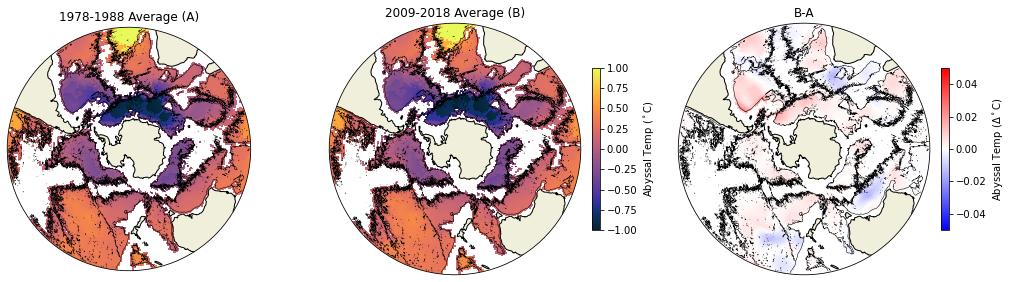

In [10]:
fig  = plt.figure(1, figsize = (22.5*0.75, 7.5*0.75))
gs = gridspec.GridSpec(1,3, width_ratios = [0.9,1,1])
gs.update(wspace = 0.3, hspace=0)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax1, ax2, ax3 = plt.subplot(gs[0,0], projection=ccrs.SouthPolarStereo()), \
           plt.subplot(gs[0,1], projection=ccrs.SouthPolarStereo()), \
           plt.subplot(gs[0,2], projection=ccrs.SouthPolarStereo())

im1 = abyssal_t_EN4_early.where(abyssal_t_EN4_early!=0).plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=cmocean.thermal, add_colorbar=False)
ax1.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='k',linewidths=0.5, transform = ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('1978-1988 Average (A)')
ax1.add_feature(cfeature.LAND)
ax1.set_boundary(circle, transform=ax1.transAxes)

im1 = abyssal_t_EN4_late.where(abyssal_t_EN4_late!=0).plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=cmocean.thermal, add_colorbar=False)
ax2.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='k',linewidths=0.5, transform = ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('2009-2018 Average (B)')
ax2.add_feature(cfeature.LAND)
ax2.set_boundary(circle, transform=ax2.transAxes)

im3 = (abyssal_t_EN4_late-abyssal_t_EN4_early).where((abyssal_t_EN4_late-abyssal_t_EN4_early)!=0).plot.pcolormesh(ax=ax3, transform=ccrs.PlateCarree(), vmin=-0.05, vmax=0.05, cmap=plt.cm.bwr, add_colorbar=False)
ax3.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='k',linewidths=0.5, transform = ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('B-A')
ax3.add_feature(cfeature.LAND)
ax3.set_boundary(circle, transform=ax3.transAxes)

cb1 = plt.colorbar(im1, ax=ax2, fraction=0.03, pad=0.04)
cb2 = plt.colorbar(im3, ax=ax3, fraction=0.03, pad=0.04)

cb1.set_label('Abyssal Temp ($^\circ$C)')
cb2.set_label('Abyssal Temp ($\Delta^\circ$C)')

# plt.savefig(figdir+'Abyssal_temp.png', bbox_inches='tight', dpi=300)
plt.show()

In [13]:
depth_slice = slice(1000,4000) #slice(6000,None) ???

temp_EN4_early = EN4_CT_SA.Cons_Temp.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('1979-01-01','1988-12-31')) 
temp_EN4_late = EN4_CT_SA.Cons_Temp.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('2009-01-01','2018-12-31'))

vol_EN4_early = EN4_CT_SA.dVol.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('1979-01-01','1988-12-31'))
vol_EN4_late = EN4_CT_SA.dVol.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('2009-01-01','2018-12-31'))

#depth average
abyssal_t_EN4_late = (temp_EN4_late*vol_EN4_late).sum('depth').mean('time')/(vol_EN4_late).sum('depth').mean('time')
abyssal_t_EN4_early = (temp_EN4_early*vol_EN4_early).sum('depth').mean('time')/(vol_EN4_early).sum('depth').mean('time')

In [14]:
abyssal_t_EN4_late.load()
abyssal_t_EN4_early.load()


<xarray.DataArray (lat: 61, lon: 360)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [2.40095748, 2.40092797, 2.39833157, ..., 2.40766675, 2.40530949,
        2.40253426],
       [2.43265445, 2.43239308, 2.43132025, ..., 2.43953356, 2.43731691,
        2.43459375],
       [2.46645863, 2.46548122, 2.46431037, ..., 2.47411075, 2.4717661 ,
        2.46882852]])
Coordinates:
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * lat      (lat) float32 -80.0 -79.0 -78.0 -77.0 ... -23.0 -22.0 -21.0 -20.0

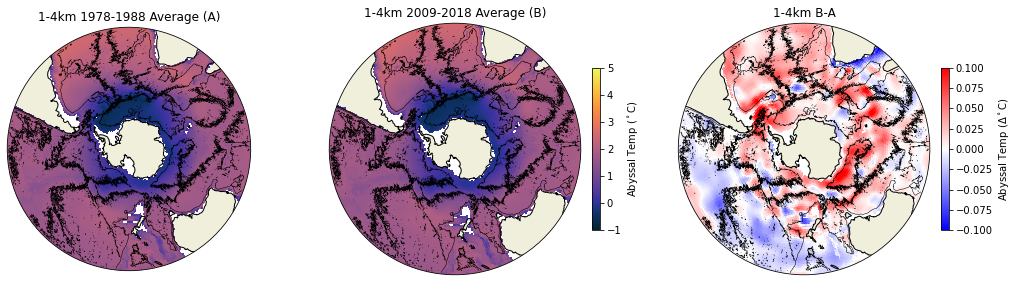

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/process.py", line 188, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/nanny.py", line 981, in _run
    asyncio.run(run())
  File "/g/data/hh5/public/apps/miniconda3/

In [16]:
fig  = plt.figure(1, figsize = (22.5*0.75, 7.5*0.75))
gs = gridspec.GridSpec(1,3, width_ratios = [0.9,1,1])
gs.update(wspace = 0.3, hspace=0)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax1, ax2, ax3 = plt.subplot(gs[0,0], projection=ccrs.SouthPolarStereo()), \
           plt.subplot(gs[0,1], projection=ccrs.SouthPolarStereo()), \
           plt.subplot(gs[0,2], projection=ccrs.SouthPolarStereo())

im1 = abyssal_t_EN4_early.where(abyssal_t_EN4_early!=0).plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), vmin=-1, vmax=5, cmap=cmocean.thermal, add_colorbar=False)
ax1.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='k',linewidths=0.5, transform = ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('1-4km 1978-1988 Average (A)')
ax1.add_feature(cfeature.LAND)
ax1.set_boundary(circle, transform=ax1.transAxes)

im1 = abyssal_t_EN4_late.where(abyssal_t_EN4_late!=0).plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmin=-1, vmax=5, cmap=cmocean.thermal, add_colorbar=False)
ax2.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='k',linewidths=0.5, transform = ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('1-4km 2009-2018 Average (B)')
ax2.add_feature(cfeature.LAND)
ax2.set_boundary(circle, transform=ax2.transAxes)

im3 = (abyssal_t_EN4_late-abyssal_t_EN4_early).where((abyssal_t_EN4_late-abyssal_t_EN4_early)!=0).plot.pcolormesh(ax=ax3, transform=ccrs.PlateCarree(), vmin=-0.1, vmax=0.1, cmap=plt.cm.bwr, add_colorbar=False)
ax3.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='k',linewidths=0.5, transform = ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('1-4km B-A')
ax3.add_feature(cfeature.LAND)
ax3.set_boundary(circle, transform=ax3.transAxes)

cb1 = plt.colorbar(im1, ax=ax2, fraction=0.03, pad=0.04)
cb2 = plt.colorbar(im3, ax=ax3, fraction=0.03, pad=0.04)

cb1.set_label('Abyssal Temp ($^\circ$C)')
cb2.set_label('Abyssal Temp ($\Delta^\circ$C)')

# plt.savefig(figdir+'Abyssal_temp.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
tmp=EN4_CT_SA.Cons_Temp.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('1981-01-01','1990-12-31')).resample({'time':'Y'}).mean('time')

vol = EN4_CT_SA.dVol.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('1981-01-01','1990-12-31')).resample({'time':'Y'}).mean('time')

#depth average
tmp2 = (tmp*vol).sum('depth')/(tmp).sum('depth')
tmp2.load()

In [ ]:
EN4_tr81to90_T_4to6=np.zeros((tmp2.shape[1],tmp2.shape[2]))


for j in range(0,tmp2.shape[1]):
    #print j
    
    EN4_tr81to90_T_4to6[j,:]=np.polyfit(range(14), tmp2[0:14,j,:],1)[0,:]


In [11]:
#the trend method below isway too slow ... why????
#calculate linear trends
#https://gist.github.com/rabernat/bc4c6990eb20942246ce967e6c9c3dbe
# define a function to compute a linear trend of a timeseries
#tmp=tmp.polyfit(dim='time',deg=1,skipna=False,full=True)

def linear_trend(x):
    yrs=np.arange(0,x.time.shape[0],1)
    pf = np.polyfit(yrs, x, 1,full=True)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(pf[0])

In [12]:
tmp=EN4_CT_SA.Cons_Temp.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('1980-01-01','1989-12-31')).resample({'time':'Y'}).mean('time')

vol = EN4_CT_SA.dVol.sel(depth=depth_slice).sel(lat=lat_slice).sel(time=slice('1980-01-01','1989-12-31')).resample({'time':'Y'}).mean('time')

#depth average
tmp2 = (tmp*vol).sum('depth')/(tmp).sum('depth')
tmp2

<xarray.DataArray (time: 10, lat: 61, lon: 360)>
dask.array<truediv, shape=(10, 61, 360), dtype=float64, chunksize=(1, 61, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * lat      (lat) float32 -80.0 -79.0 -78.0 -77.0 ... -23.0 -22.0 -21.0 -20.0
  * time     (time) datetime64[ns] 1980-12-31 1981-12-31 ... 1989-12-31

In [13]:
#this is way too slow ... why????

#https://gist.github.com/rabernat/bc4c6990eb20942246ce967e6c9c3dbe
# stack lat and lon into a single dimension called allpoints
stacked = tmp2.stack(allpoints=['lat','lon'])
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked = trend.unstack('allpoints')

trend_1980s_4km=trend_unstacked.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  retu

# Basin-specific time series

In [18]:
Basins = np.array(['Ross Sector','Weddell Sector','Australian Antarctic Sector','East Antarctic Sector','Amundsen Sector'])

lon_slice = np.array([slice(-215,-130),slice(-70,0),slice(-280,-215),slice(0,80),slice(-130,-70)])
lon_slice_EN4 = np.array([slice(-215,-130),slice(-70,0),slice(-280,-215),slice(-360,-280),slice(-130,-70)])

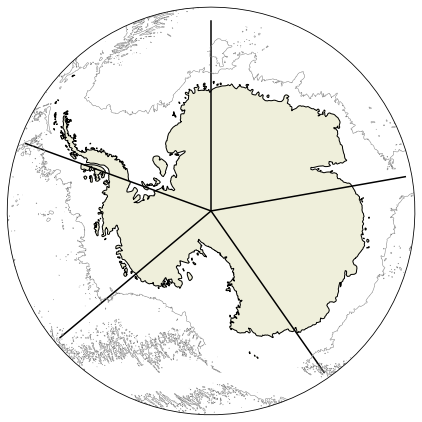

In [19]:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)

fig  = plt.figure(1, figsize = (7.5, 7.5))
gs = gridspec.GridSpec(1,1)#, width_ratios = [0.9,1])
# gs.update(wspace = 0.1, hspace=0.15)

ax1 = plt.subplot(gs[0,0], projection=ccrs.SouthPolarStereo())

ax1.plot([-130,-130], [-90,-60.000001],'k', transform=ccrs.PlateCarree())
ax1.plot([0,0], [-90,-61],'k', transform=ccrs.PlateCarree())
ax1.plot([-215,-215], [-90,-60.000001],'k', transform=ccrs.PlateCarree())
ax1.plot([80,80], [-90,-60.000001],'k', transform=ccrs.PlateCarree())
ax1.plot([-70,-70], [-90,-60.000001], 'k', transform=ccrs.PlateCarree())

# -280,-280,
ax1.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='grey',linewidths=0.5, transform = ccrs.PlateCarree())
ax1.coastlines()
ax1.set_boundary(circle, transform=ax1.transAxes)

# ax1.set_extent([-180,180,-90,-40])
ax1.add_feature(cfeature.LAND)
plt.savefig(figdir+'Basins_definitions.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# whole time period:
start_time='1979-01-01'
end_time='2018-12-31'


volume_basins = []
volume_basins_sum = []
for i in tqdm(range(Basins.size)):
    print(Basins[i])
    # thickness / area for depth averaging (not time varying):

    xt_ocean = cc.querying.getvar(control,'xt_ocean' , master_session,n=1)
    yt_ocean = cc.querying.getvar(control,'yt_ocean' , master_session,n=1)
    yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)
    xt_ocean = xt_ocean.sel(xt_ocean=lon_slice[i])
    # import edges of st_ocean and add lat/lon dimensions:
    st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, n=1)
    st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean}, axis=[1,2])

    # adjust edges at bottom for partial thickness:
    ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice[i])
    st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
    thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

    # change coordinate of thickness to st_ocean (needed for multipling with other variables):
    st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
    thickness['st_edges_ocean'] = st_ocean.values
    thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

    # area for area averaging:

    area_t = cc.querying.getvar(control,'area_t',master_session,n=1)
    area_t = area_t.where(ht>4000)
    area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice[i])

    volume = area_t*thickness
    volume_basins.append(volume.load())
    volume_sum = volume_basins[i].sum()
    volume_basins_sum.append(volume_sum.load())

  0%|          | 0/5 [00:00<?, ?it/s]

Ross Sector


 20%|██        | 1/5 [00:38<02:33, 38.30s/it]

Weddell Sector


 40%|████      | 2/5 [01:09<01:42, 34.31s/it]

Australian Antarctic Sector


 60%|██████    | 3/5 [01:40<01:05, 32.78s/it]

East Antarctic Sector


 80%|████████  | 4/5 [02:09<00:31, 31.07s/it]

Amundsen Sector


2022-12-13 10:43:43,856 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
100%|██████████| 5/5 [02:35<00:00, 31.18s/it]


In [21]:
temp_con_basins = []
temp_melt_basins = []
sal_con_basins = []
sal_melt_basins = []
for i in tqdm(range(Basins.size)):
    temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice[i]).sel(st_ocean=depth_slice)
    # area and depth averaging in AAB (volume contains region mask):
    temp_con = (temp_con*volume_basins[i]).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_basins_sum[i]
    temp_con_basins.append(temp_con.load())

    temp_melt = cc.querying.getvar(iaf_melt, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_melt = temp_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice[i]).sel(st_ocean=depth_slice)
    temp_melt = (temp_melt*volume_basins[i]).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_basins_sum[i]
    temp_melt_basins.append(temp_melt.load())
    
    sal_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    sal_con = sal_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice[i]).sel(st_ocean=depth_slice)
    # area and depth averaging in AAB (volume contains region mask):
    sal_con = (sal_con*volume_basins[i]).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_basins_sum[i]
    sal_con_basins.append(sal_con.load())

    sal_melt = cc.querying.getvar(iaf_melt, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    sal_melt = sal_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice[i]).sel(st_ocean=depth_slice)
    sal_melt = (sal_melt*volume_basins[i]).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_basins_sum[i]
    sal_melt_basins.append(sal_melt.load())

  0%|          | 0/5 [00:00<?, ?it/s]2022-12-13 10:44:06,872 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-12-13 10:44:10,931 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x150e3e9201f0>>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/utils_perf.py", line 179, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
Process Dask Worker process (from Nanny):
2022-12-13 10:44:30,505 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/publ

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(24*0.5,6*0.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()

colors = ['k', 'r', 'g', 'b', 'm']

for i in range(Basins.size):
    (temp_melt_basins[i]-temp_con_basins[i]).plot(ax = axs[0], label=Basins[i], color=colors[i])
    (sal_melt_basins[i]-sal_con_basins[i]).plot(ax = axs[1], label=Basins[i], color=colors[i])

for i in range(2):
    axs[i].set_xlim(temp_con_basins[i].time.min(), temp_con_basins[i].time.max())
    axs[i].grid()
    # axs[i].set_title('Melt minus Control')
    axs[i].set_xlabel('Year')

axs[0].legend(ncol=2)
axs[0].set_ylabel('Abyssal Temp. Anomaly')
axs[1].set_ylabel('Abyssal Salinity Anomaly (g/kg)')

axs[0].legend(framealpha=1, ncol=3, bbox_to_anchor=(1.05,-0.43), loc='center')
plt.savefig(figdir+'T_S_anomaly_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(24,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.3)
axs = axs.ravel()

colors = ['k', 'r', 'g', 'b', 'm']
graph_inds = [0,4,1,3,2]

for i in range(Basins.size):
    (temp_con_basins[graph_inds[i]]).plot(ax = axs[i], label='Control', color=colors[graph_inds[i]], linestyle='dashed')
    (temp_melt_basins[graph_inds[i]]).plot(ax = axs[i], label='Melt', color=colors[graph_inds[i]])
    axs[i].set_title(Basins[graph_inds[i]])

    (sal_con_basins[graph_inds[i]]).plot(ax = axs[i+5], label='Control', color=colors[graph_inds[i]], linestyle='dashed')
    (sal_melt_basins[graph_inds[i]]).plot(ax = axs[i+5], label='Melt', color=colors[graph_inds[i]])

for i in range(Basins.size):
    axs[i].set_xlim(temp_con_basins[i].time.min(), temp_con_basins[i].time.max())
    axs[i].grid()
    axs[i+5].set_xlim(temp_con_basins[i].time.min(), temp_con_basins[i].time.max())
    axs[i+5].grid()
    axs[i+5].set_xlabel('Year')
    axs[i+5].set_xlabel('')
    axs[i].set_xticklabels([''])
    axs[i].legend(ncol=2)
    axs[i+5].legend(ncol=2)


axs[0].legend(ncol=2)
axs[0].set_ylabel('Abyssal Temp.')
axs[5].set_ylabel('Abyssal Salinity (g/kg)')

axs[0].legend(ncol=2)
plt.savefig(figdir+'T_S_basins_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
EN4_CT_SA = xr.open_mfdataset(path_EN4)
EN4_CT_SA.coords['lon'] = EN4_CT_SA.coords['lon'] - 360

In [ ]:
if East_Antarctic_sector:
    temp_EN4 = EN4_CT_SA.Cons_Temp.sel(depth=depth_slice).sel(lat=lat_slice).sel(lon=lon_slice_EN4)
    sal_EN4 = EN4_CT_SA.Abs_Sal.sel(depth=depth_slice).sel(lat=lat_slice).sel(lon=lon_slice_EN4)
    vol_EN4 = EN4_CT_SA.dVol.sel(depth=depth_slice).sel(lat=lat_slice).sel(lon=lon_slice_EN4)*temp_EN4/temp_EN4
else:
    temp_EN4 = EN4_CT_SA.Cons_Temp.sel(depth=depth_slice).sel(lat=lat_slice).sel(lon=lon_slice)
    sal_EN4 = EN4_CT_SA.Abs_Sal.sel(depth=depth_slice).sel(lat=lat_slice).sel(lon=lon_slice)
    vol_EN4 = EN4_CT_SA.dVol.sel(depth=depth_slice).sel(lat=lat_slice).sel(lon=lon_slice)*temp_EN4/temp_EN4

vol_EN4 = vol_EN4.load()
    
temp_EN4 = (temp_EN4*vol_EN4).sum('lon').sum('lat').sum('depth')/(vol_EN4.sum('lon').sum('lat').sum('depth'))
temp_EN4 = temp_EN4.load()

sal_EN4 = (sal_EN4*vol_EN4).sum('lon').sum('lat').sum('depth')/(vol_EN4.sum('lon').sum('lat').sum('depth'))
sal_EN4 = sal_EN4.load()

In [ ]:
fontsize=13
if Ross_sector:
if Weddell_sector:
    plt.figure(figsize=(10,6))

    temp_con.plot(label='Control')
    temp_melt.plot(label='Meltwater')
    plt.legend(fontsize=fontsize)
    plt.title('Abyssal temperature in Weddell Sector',fontsize=fontsize)
    plt.ylabel('Temperature',fontsize=fontsize)
    plt.xlabel('Year',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.savefig(figdir+'Abyssal_T_Weddell.png', dpi=300, bbox_inches='tight')
    plt.show()
if Australian_Antarctic_sector:
    plt.figure(figsize=(10,6))

    temp_con.plot(label='Control')
    temp_melt.plot(label='Meltwater')
    plt.legend(fontsize=fontsize)
    plt.title('Abyssal temperature in Australian Antarctic Sector',fontsize=fontsize)
    plt.ylabel('Temperature',fontsize=fontsize)
    plt.xlabel('Year',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.savefig(figdir+'Abyssal_T_AAS.png', dpi=300, bbox_inches='tight')
    plt.show()
if East_Antarctic_sector:
    plt.figure(figsize=(10,6))

    temp_con.plot(label='Control')
    temp_melt.plot(label='Meltwater')
    plt.legend(fontsize=fontsize)
    plt.title('Abyssal temperature in Ross Sector',fontsize=fontsize)
    plt.ylabel('Temperature',fontsize=fontsize)
    plt.xlabel('Year',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.savefig(figdir+'Abyssal_T_EAS.png', dpi=300, bbox_inches='tight')
    plt.show()
if Amundsen_sector:
    plt.figure(figsize=(10,6))

    temp_con.plot(label='Control')
    temp_melt.plot(label='Meltwater')
    plt.legend(fontsize=fontsize)
    plt.title('Abyssal temperature in Amundsen Sector',fontsize=fontsize)
    plt.ylabel('Temperature',fontsize=fontsize)
    plt.xlabel('Year',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.savefig(figdir+'Abyssal_T_Amun.png', dpi=300, bbox_inches='tight')
    plt.show()

